In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

Original network stats:
Number of nodes: 786
Number of edges: 14024
Average clustering coefficient: 0.4757300518398769
Is connected: False
Size of giant cluster: 775
Performing random node deletion...


100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


Performing targeted node deletion (by degree)...


100%|██████████| 20/20 [01:09<00:00,  3.47s/it]


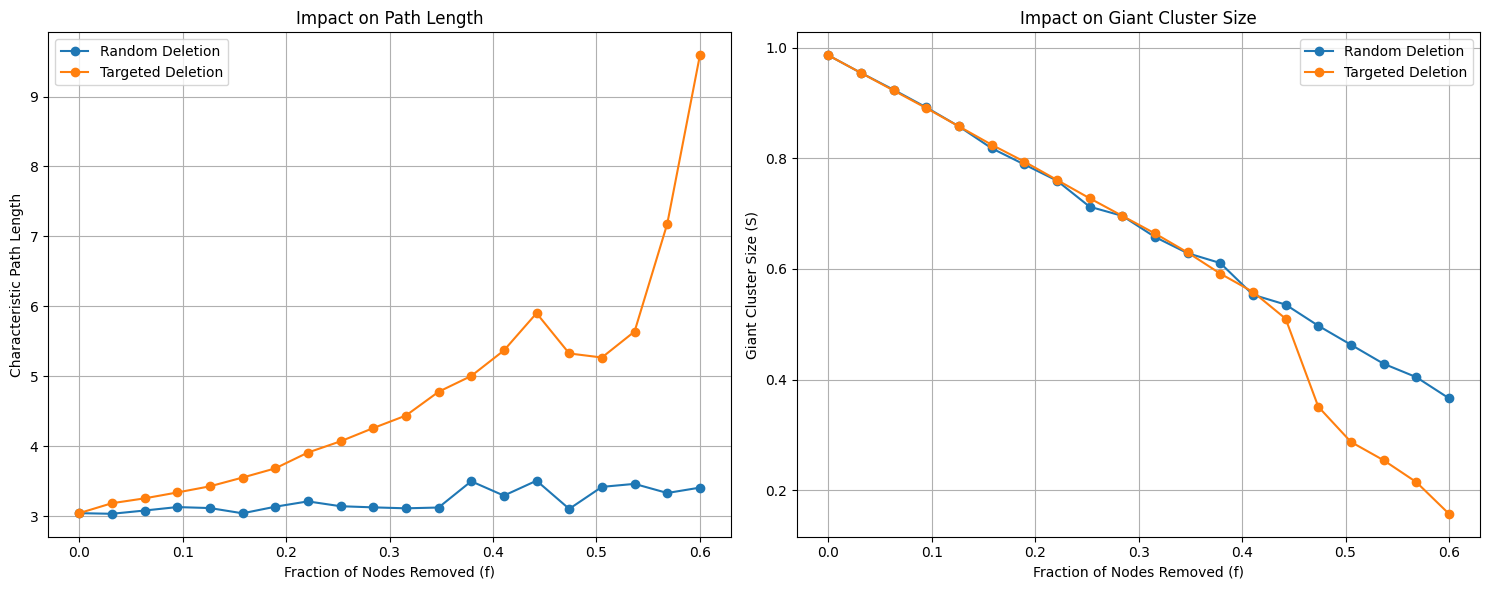

Critical point for random deletion: f_c ≈ 0.600
Critical point for targeted deletion: f_c ≈ 0.474
Output Implicatoins:
The critical point for random deletion is more than the targeted deletion. This means that the network is more robust to random failures than to targeted attacks. The network is scale-free, because the giant cluster size decreases slowly with node removal and falls immediately in the case of targeted deletion. The path length increases faster in targeted deletion than in random deletion.

Observations compared to Albert et al. (2000):
The graph appears to be scale-free, because the giant cluster size decreases slowly with node removal. Just like in the paper, in targeted deletion the giant cluster size decreases faster than in random deletion. Similarly to the paper, my results are resonating with the idea that the network is robust to random failures but vulnerable to targeted attacks. And in the case of path length the results are also similar to the paper, the path 

In [ ]:
edge_list = pd.read_csv('edge_list.csv')
G = nx.from_pandas_edgelist(edge_list, 'Source', 'Target')
num = G.number_of_nodes()

print(f"Original network stats:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average clustering coefficient: {nx.average_clustering(G)}")
print(f"Is connected: {nx.is_connected(G)}")
large = max(nx.connected_components(G), key=len)
print(f"Size of giant cluster: {len(large)}")


def charLen(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        largCC =max(nx.connected_components(G), key=len)
        larGraph= G.subgraph(largCC)
        return nx.average_shortest_path_length(larGraph)

def giantCluster(G, original_size):
    if not G.nodes():
        return 0
    largest_cc =max(nx.connected_components(G), key=len)
    return len(largest_cc) / original_size


def delRand(G_original, fractions):
    results = {'f': [], 'path_length': [], 'giant_cluster_size': []}
    print("Performing random node deletion...")
    for f in tqdm(fractions):
        G = G_original.copy()
        removeNum = int(f *num)
        nodes_to_remove = np.random.choice(list(G.nodes()),size=removeNum, replace=False)
        G.remove_nodes_from(nodes_to_remove)
        if G.nodes():
            try:
                PL =charLen(G)
            except nx.NetworkXError:
                PL = float('inf')
            clusSize =giantCluster(G, num)
            results['f'].append(f)
            results['path_length'].append(PL)
            results['giant_cluster_size'].append(clusSize)

    return results


def delTar(G_original, fractions):
    results = {'f': [], 'path_length': [], 'giant_cluster_size': []}
    print("Performing targeted node deletion (by degree)...")
    for f in tqdm(fractions):
        G = G_original.copy()
        removeNum = int(f * num)
        for _ in range(removeNum):
            if G.nodes():
                node_degrees = dict(G.degree())
                if not node_degrees:
                    break
                highest_degree_node = max(node_degrees, key=node_degrees.get)
                G.remove_node(highest_degree_node)
            else:
                break
        if G.nodes():
            try:
                path_length = charLen(G)
            except nx.NetworkXError:
                path_length = float('inf')
            clusSize = giantCluster(G, num)
            results['f'].append(f)
            results['path_length'].append(path_length)
            results['giant_cluster_size'].append(clusSize)

    return results


fractions = np.linspace(0, 0.6, 20) 
rand = delRand(G, fractions)
tar = delTar(G, fractions)


plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(rand['f'], rand['path_length'],'o-', label='Random Deletion')
plt.plot(tar['f'], tar['path_length'],'o-', label='Targeted Deletion')
plt.xlabel('Fraction of Nodes Removed (f)')
plt.ylabel('Characteristic Path Length')
plt.title('Impact on Path Length')
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(rand['f'], rand['giant_cluster_size'],'o-', label='Random Deletion')
plt.plot(tar['f'], tar['giant_cluster_size'],'o-', label='Targeted Deletion')
plt.xlabel('Fraction of Nodes Removed (f)')
plt.ylabel('Giant Cluster Size (S)')
plt.title('Impact on Giant Cluster Size')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('plot.png', dpi=300)
plt.show()


def find_critical_point(fractions, gcSizes):
    derivatives = np.gradient(gcSizes, fractions)
    critical = np.argmin(derivatives)
    return fractions[critical]


criticalRand = find_critical_point(np.array(rand['f']), np.array(rand['giant_cluster_size']))
criticalTar = find_critical_point(np.array(tar['f']), np.array(tar['giant_cluster_size']))

print(f"Critical point for random deletion: f_c ≈ {criticalRand:.3f}")
print(f"Critical point for targeted deletion: f_c ≈ {criticalTar:.3f}")


print("Output Implicatoins:")
print("The critical point for random deletion is more than the targeted deletion. This means that the network is more robust to random failures than to targeted attacks. The network is scale-free, because the giant cluster size decreases slowly with node removal and falls immediately in the case of targeted deletion. The path length increases faster in targeted deletion than in random deletion.")
print("\nObservations compared to Albert et al. (2000):")
print("The graph appears to be scale-free, because the giant cluster size decreases slowly with node removal. Just like in the paper, in targeted deletion the giant cluster size decreases faster than in random deletion. Similarly to the paper, my results are resonating with the idea that the network is robust to random failures but vulnerable to targeted attacks. And in the case of path length the results are also similar to the paper, the path length increases faster in targeted deletion than in random deletion. Also in random deletion the path length sommewhat remains constant until a certain point, after which it increases rapidly. In targeted deletion the path length increases more linearly.")  
